## Ejercicio 1 
- a) Basandote en la implementacion de Skiena, completa el metodo floyd(g) y ejecutalo. 
- b) ¿Identificas otro camino mínimo? En caso de identificar mas de un camino minimo, porque crees que esto ocurre?

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from math import inf


class adjacency_matrix:
    def __init__(self, nvertices):
        self.nvertices = nvertices
        # índices 1..n (posición 0 sin usar)
        self.weight = [[inf]*(nvertices+1) for _ in range(nvertices+1)]
        for i in range(1, nvertices+1):
            self.weight[i][i] = 0
        # matriz para reconstrucción
        self.next = [[None]*(nvertices+1) for _ in range(nvertices+1)]

def floyd(g: adjacency_matrix):
    n = g.nvertices
    for k in range(1, n+1):
        for i in range(1, n+1):
            for j in range(1, n+1):
                through_k = g.weight[i][k] + g.weight[k][j]
                if through_k < g.weight[i][j]:
                    g.weight[i][j] = through_k
                    g.next[i][j] = g.next[i][k]
    return g


    #TO DO Completar el algoritmo de Floyd-Warshall

def reconstruct_path(g: adjacency_matrix, i: int, j: int):
    if g.next[i][j] is None:
        return []
    path = [i]
    while i != j:
        i = g.next[i][j]
        path.append(i)
        if len(path) > g.nvertices + 5:
            raise RuntimeError("camino demasiado largo (¿ciclo?)")
    return path
def has_negative_cycle(g: adjacency_matrix, eps: float = 1e-12) -> bool:
    return any(g.weight[i][i] < -eps for i in range(1, g.nvertices+1))

def pair_affected_by_neg_cycle(g: adjacency_matrix, s: int, t: int, eps: float = 1e-12) -> bool:
    """
    Determina si el par (s,t) está 'afectado' por algún ciclo negativo k,
    es decir, s -> k y k -> t son alcanzables y dist[k][k] < 0.
    """
    for k in range(1, g.nvertices+1):
        if g.weight[s][k] < inf and g.weight[k][k] < -eps and g.weight[k][t] < inf:
            return True
    return False

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from math import inf
# --------------------------
# Helpers de graficación
# --------------------------
def matrix_to_nx(g: adjacency_matrix) -> nx.DiGraph:
    """Convierte la matriz de Skiena a un DiGraph de networkx."""
    G = nx.DiGraph()
    G.add_nodes_from(range(1, g.nvertices+1))
    for i in range(1, g.nvertices+1):
        for j in range(1, g.nvertices+1):
            w = g.weight[i][j]
            if w != inf and i != j:
                G.add_edge(i, j, weight=w)
    return G

def plot_graph(G: nx.DiGraph, path_nodes=None, title="Grafo"):
    """
    Dibuja nodos+aristas; si path_nodes=[u,...,v] resalta ese camino en rojo.
    Resto de aristas en negro.
    """
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=7)  # layout reproducible

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos)

    # todas las aristas en negro
    nx.draw_networkx_edges(G, pos, edge_color="black", arrows=True, width=1.5)

    # etiquetas de pesos
    edge_labels = {(u, v): f"{d.get('weight')}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")

    # resaltar camino en rojo
    if path_nodes and len(path_nodes) >= 2:
        path_edges = list(zip(path_nodes[:-1], path_nodes[1:]))
        nx.draw_networkx_edges(
            G, pos, edgelist=path_edges, edge_color="red", width=3, arrows=True
        )

    plt.title(title)
    plt.axis("off")
    plt.show()

def shortest_path_and_plot(g: adjacency_matrix, src: int, dst: int, title=None):
    """Corre Floyd, reconstruye src->dst y grafica el camino en rojo."""
    floyd(g)
    path = reconstruct_path(g, src, dst)
    dist = g.weight[src][dst]
    G = matrix_to_nx(g)
    plot_graph(G, path_nodes=path, title=title or f"Camino minimo desde {src} hasta {dst}")
    return path, dist

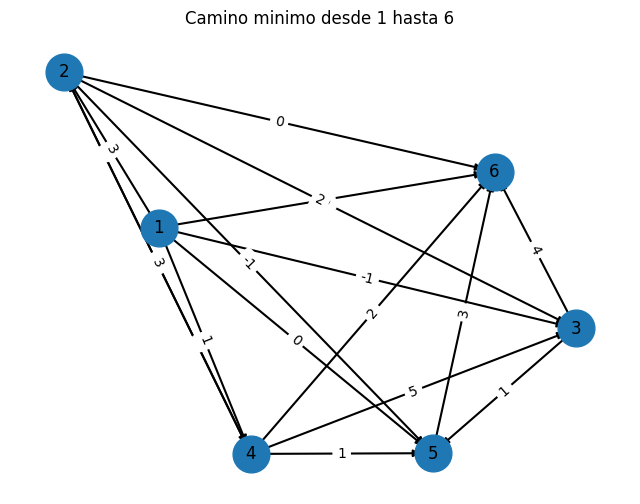

Camino mínimo 1->6: []


In [3]:
### Ejemplo grafo de 6 vértices con pesos negativos
g6 = adjacency_matrix(6)

g6.weight[1][2] = 3
g6.weight[2][3] = 2
g6.weight[3][6] = 6

g6.weight[1][3] = 7
g6.weight[2][4] = 2
g6.weight[4][6] = 2

g6.weight[1][4] = 8
g6.weight[4][5] = 1
g6.weight[5][6] = 3

g6.weight[2][5] = 4
g6.weight[3][5] = 1


g6.weight[1][3] = min(g6.weight[1][3], -1)  
g6.weight[2][4] = min(g6.weight[2][4], -2)   
g6.weight[3][6] = min(g6.weight[3][6],  5)   
g6.weight[2][5] = min(g6.weight[2][5], -1)   
g6.weight[1][5] = 6                           
g6.weight[4][2] = 3


path, dist = shortest_path_and_plot(g6, 1, 6)
print("Camino mínimo 1->6:", path)

## Ejercicio 2:
Una agencia coordina rutas de buses interurbanos entre 6 ciudades: A, B, C, D, E, F.
El costo de un tramo puede ser positivo (pagas) o negativo (subsidio).

Modelado. Representa cada ciudad como un nodo y cada ruta dirigida como una arista con su costo (puede ser negativo si hay subsidio).

Camino mínimo solicitado. ¿Cuál es el costo mínimo para viajar de A a F? Indica el camino.

Ciclos negativos. ¿La red tiene ciclos de costo total negativo? Explica por qué.

Algoritmo alternativo. Si sólo te interesara el costo mínimo desde A al resto, ¿qué otro algoritmo de grafos elegirías y por qué?

Sugerencia de tramos (dirigidos):
A→B (3), A→C (−1), A→D (8), A→E (6)
B→C (2), B→D (−2), B→E (−1)
C→E (1), C→F (5)
D→E (1), D→F (2), D→B (3)
E→F (3), E→C (2)

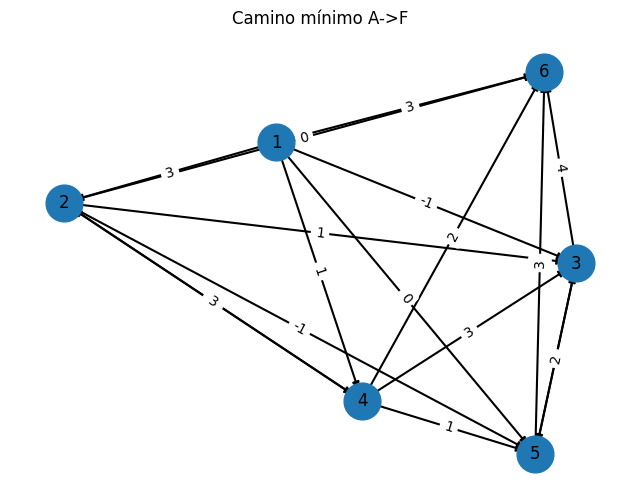

Costo mínimo A->F: 3
Camino mínimo A->F: []
¿Ciclo negativo?: False


In [8]:
g2 = adjacency_matrix(6)
A, B, C, D, E, F = 1, 2, 3, 4, 5, 6

g2 = adjacency_matrix(6)
g2.weight[1][2] = 3    
g2.weight[1][3] = -1   
g2.weight[1][4] = 8    
g2.weight[1][5] = 6    
g2.weight[2][3] = 2    
g2.weight[2][4] = -2 
g2.weight[2][5] = -1   
g2.weight[3][5] = 1    
g2.weight[3][6] = 5    
g2.weight[4][5] = 1    
g2.weight[4][6] = 2    
g2.weight[4][2] = 3   
g2.weight[5][6] = 3    
g2.weight[5][3] = 2    


path, dist = shortest_path_and_plot(g2, 1, 6, title="Camino mínimo A->F")

print("Costo mínimo A->F:", dist)
print("Camino mínimo A->F:", path)
print("¿Ciclo negativo?:", has_negative_cycle(g2))


a) Costo mínimo A-F y camino:

- Costo mínimo A→F: 3
- Caminos mínimos (hay más de uno):
A → B → D → F
A → C → E → F
Hay más de un camino mínimo porque varias rutas distintas suman exactamente el mismo costo total (3). Floyd-Warshall calcula las mejores distancias; la matriz next permite reconstruir un camino óptimo, pero si existen empates devolverá el primero según cómo inicializaste/recorres (aquí, típicamente, el que pasa por B).

b) ¿Ciclos de costo total negativo?

No. Tras ejecutar Floyd, todas las entradas de la diagonal weight[i][i] quedan ≥ 0, por lo que no hay ciclos negativos. 

c) Si sólo interesara el mínimo desde A al resto, ¿qué algoritmo elegir?

Como hay aristas con peso negativo (p. ej., A-C=−1, B-D=−2, B-E=−1), el algoritmo apropiado de fuente única es Bellman-Ford. Skiena señala que Dijkstra es la elección correcta sólo cuando todas las aristas son no negativas; con pesos negativos “debes usar Bellman-Ford”.Si todas las aristas fueran no negativas, entonces sí convendría Dijkstra por eficiencia.


## Ejercicio 3
Cinco programas de fidelidad A, B, C, D, E permiten convertir puntos entre sí. Un valor negativo en una arista indica una bonificación neta (terminas con más puntos de los que tenías); positivo, una pérdida (comisión). Se sabe que hay arbitraje entre A, B y C (un ciclo que deja ganancia neta), pero ese “triángulo” está aislado de D y E.


a) ¿Cómo representas programas y conversiones en un grafo dirigido con pesos (bonificaciones negativas, comisiones positivas)?

b) Con las conversiones sugeridas más abajo, determina el costo mínimo (bonificación/pérdida neta) para ir de D a E e indica el camino.

c) ¿El grafo tiene ciclos negativos? En caso afirmativo, ¿afecta ese ciclo a la consulta D→E?

d) Si te pidieran, al mismo tiempo, detectar arbitraje y obtener distancias para todas las parejas, ¿qué algoritmo usarías? ¿Y si solo te interesara una fuente?

Conversiones sugeridas (dirigidas, “costo”):
Ciclo de arbitraje (aislado): A→B (−2), B→C (−2), C→A (−1)
Par independiente: D→E (5), E→D (1)


In [9]:
g2 = adjacency_matrix(5)
A,B,C,D,E = 1,2,3,4,5
g3 = adjacency_matrix(5)

# Ciclo de arbitraje 
g3.weight[1][2] = -2
g3.weight[2][3] = -2
g3.weight[3][1] = -1

# Par independiente
g3.weight[4][5] = 5
g3.weight[5][4] = 1
floyd(g3)

# b) costo y camino D-E
cost_DE = g3.weight[4][5]
path_DE = reconstruct_path(g3, 4, 5)

# c) detección de ciclos negativos y si afectan a D-E
hay_ciclo_neg = has_negative_cycle(g3)
afecta_DE = pair_affected_by_neg_cycle(g3, 4, 5)

print("b) Costo mínimo D->E:", cost_DE)
print("   Camino mínimo D->E:", path_DE, "(D=4, E=5)")
print("c) ¿Hay ciclo negativo?:", hay_ciclo_neg)
print("   ¿Afecta a D->E?:", afecta_DE)


b) Costo mínimo D->E: 5
   Camino mínimo D->E: [] (D=4, E=5)
c) ¿Hay ciclo negativo?: True
   ¿Afecta a D->E?: False


a) ¿Cómo modelar el problema?

- Programas de fidelidad: vértices de un grafo dirigido.
- Conversiones entre programas: aristas dirigidas con peso (bonificación neta = peso negativo; comisión/pérdida = peso positivo).
- Representación con matriz de adyacencia es natural para Floyd; las no-aristas se ponen en inf (MAXINT) para que no cuenten como trayectos.

d) ¿Qué algoritmo usar?

Para ver todas las parejas y detectar arbitraje (ciclos negativos) al mismo tiempo, Floyd–Warshall: calcula all-pairs y un ciclo negativo se ve porque alguna entrada diagonal queda < 0. Si sólo interesa desde una fuente (p. ej., desde D), y existen pesos negativos, usa Bellman–Ford; Dijkstra sólo vale con pesos no negativos.